# Sentiment Analysis using NLP


## Introduction

In this notebook I'll build a sentiment analysis model which classifies IMDB text reviews as either positive or negative

Dataset link [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/)<Br>
    This dataset contains 25000 train reviews and 25000 test reviews, these reviews are equally balanced
    
I'll be using the following models to classify reviews:
* Naive Bayes
* Neural networks

### Importing Required libraries

In [18]:
import pandas as pd
import numpy as np

import os #to read the reviews
import pickle #to save the preprocessed reviews
import re
from collections import Counter

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from plotly.subplots import make_subplots
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected = True) #to make plotly work offline

from bs4 import BeautifulSoup
import requests

import nltk #for text preprocessing
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import strip_accents_ascii
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.naive_bayes import MultinomialNB

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, BatchNormalization

import warnings
warnings.filterwarnings('ignore')

#### Specifying the path to directories

In [2]:
os.chdir(os.path.join(os.getcwd(),os.listdir()[1])) #this will change the path to dataset directory
train_dir = os.path.join(os.getcwd(),'train')
train_pos = os.path.join(train_dir,'pos')
train_neg = os.path.join(train_dir,'neg')

test_dir = os.path.join(os.getcwd(),'test')
test_pos = os.path.join(test_dir,'pos')
test_neg = os.path.join(test_dir,'neg')

#### Loading the data as dataframe

In [3]:
# below function will load the review and it's class (pos-1/neg-0)
def read_reviews(directory,review_value=None):
    reviews = []
    target = []
    for txt in os.listdir(directory):
        with open(os.path.join(directory,txt),encoding="utf8") as text:
            reviews.append(text.read())
        target.append(review_value)
    return reviews,target

pos_x,pos_y = read_reviews(train_pos,review_value=1)
neg_x,neg_y = read_reviews(train_neg,review_value=0)
df = pd.DataFrame({'Review':pos_x+neg_x,
                   'Rating':pos_y+neg_y
                  })
df.head()

,Review,Rating
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [4]:
pos_test_x,pos_test_y = read_reviews(test_pos,review_value=1)
neg_test_x,neg_test_y = read_reviews(test_neg,review_value=0)
df_test = pd.DataFrame({'Review':pos_test_x+neg_test_x,
                   'Rating':pos_test_y+neg_test_y
                  })
df_test.head()

,Review,Rating
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


#### Need to clean all the reviews by getting rid of symbols, html tags, capital letters and stopwords

* I used regex to remove symbols & some html tags and BeautifulSoup to get rid of any extra html tags
* To remove stopwords I used nltk's stopwords

but nltk's stop words doesn't include contractions, so I'll be scraping them from [wikipedia](https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) to remove contractions from reviews

In [5]:
pos_x[1]

'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they\'ll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it\'s like to be homeless? That is Goddard Bolt\'s lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days withou

In [6]:
#this below function will scrape contractions and store it in a dictionary file
#eg {"aren't" : "are not"}

def contractions():
    contractions_dict = {}
    url = 'https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions'
    request = requests.get(url).text
    soup = BeautifulSoup(request,'html.parser')
    table = soup.find_all('tbody')[1]
    contractions_list = [re.sub(r'(\(.+\))|(\[\d\])','',x.text).strip() for x in table.find_all('td')]
    for i in range(len(contractions_list)):
        if i%2 == 0:
            contractions_dict[contractions_list[i]] = contractions_list[i+1]
    return contractions_dict

contractions = contractions()

#saving contractions to a pickle file
with open('contractions.pkl','wb') as f:
    pickle.dump(contractions,f)


stop_words = nltk.corpus.stopwords.words('english')+list(contractions.keys())

# to tokenize and lemmatize the words
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=True)
lemmatizer = WordNetLemmatizer()

# function to clean reviews
def cleaner(text):
    text = text.strip()
    text = strip_accents_ascii(text)
    text = re.sub(r'(<br />)|(<br>)|(<br >)',' ',text)
    soup = BeautifulSoup(text,'html.parser')
    text = soup.get_text()
    text = [lemmatizer.lemmatize(x) for x in tokenizer.tokenize(text) if x not in stop_words]
    text = re.sub(r'[^A-Za-z ]','',' '.join(text))
    return text

cleaner(pos_x[1])

'homelessness  houselessness george carlin stated  issue year never plan help street considered human everything going school  work  vote matter  people think homeless lost cause worrying thing racism  war iraq  pressuring kid succeed  technology  election  inflation  worrying next end street  given bet live street month without luxury home  entertainment set  bathroom  picture wall  computer  everything treasure see like homeless  goddard bolts lesson  mel brook  directs  star bolt play rich man everything world deciding make bet sissy rival  jeffery tambor  see live street thirty day without luxury  bolt succeeds  want future project making building  bets bolt thrown street bracelet leg monitor every move step sidewalk  given nickname pepto vagrant written forehead bolt meet character including woman name molly  lesley ann warren  exdancer got divorce losing home  pal sailor  howard morris  fume  teddy wilson  already used street  survivor  bolt  used reaching mutual agreement like r

In [7]:
df['Review'] = df['Review'].apply(cleaner)
df_test['Review'] = df_test['Review'].apply(cleaner)

with open('train_reviews.pkl','wb') as clean_reviews:
    pickle.dump(df,clean_reviews)

with open('test_reviews.pkl','wb') as clean_reviews:
    pickle.dump(df_test,clean_reviews)

df.head()

,Review,Rating
0,bromwell high cartoon comedy ran time program...,1
1,homelessness houselessness george carlin stat...,1
2,brilliant overacting lesley ann warren best d...,1
3,easily underrated film inn brook cannon sure ...,1
4,typical mel brook film much le slapstick movi...,1


#### Let's Visualize the top words in positive and negative texts using wordcloud

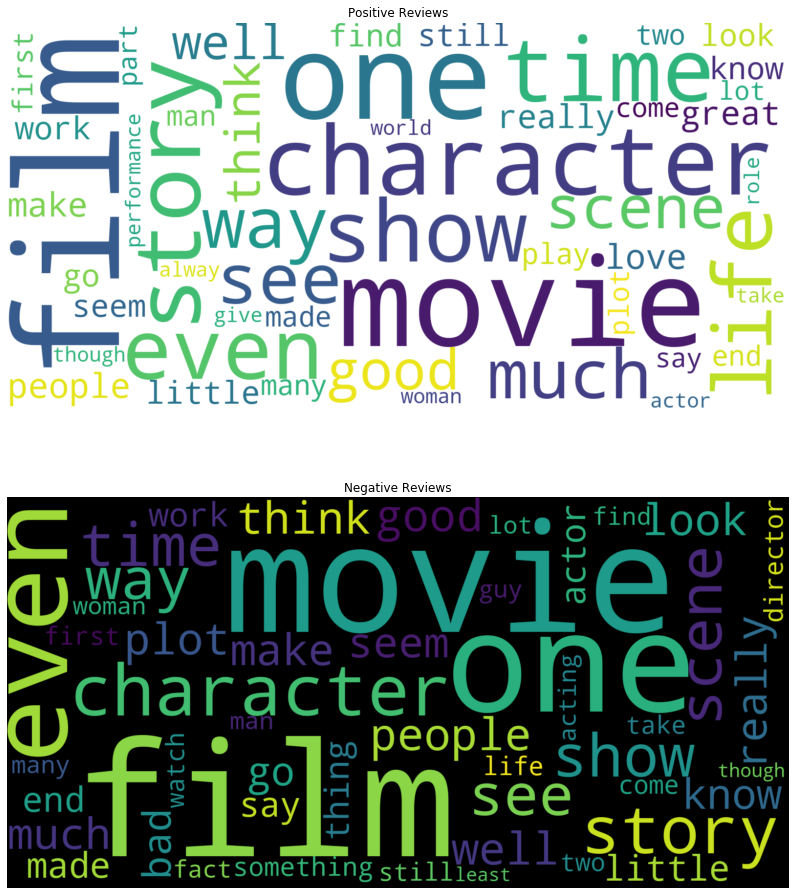

In [8]:
pos_text = ' '.join(list(df[df['Rating']==1]['Review'].values))
neg_text = ' '.join(list(df[df['Rating']==0]['Review'].values))
pos_cloud = WordCloud(width = 1600,height = 800,background_color='white',min_font_size = 10,max_words=50).generate(pos_text)
neg_cloud = WordCloud(width = 1600,height = 800,background_color='black',min_font_size = 10,max_words=50).generate(neg_text)

fig,ax = plt.subplots(2,1,figsize=(14,16))
ax[0].imshow(pos_cloud, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title('Positive Reviews')
ax[1].imshow(neg_cloud, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title('Negative Reviews')
plt.show()

In [9]:
def top_words(pos,neg,words=10):
    pos_dict = dict(Counter(pos.split()).most_common(words))
    neg_dict = dict(Counter(neg.split()).most_common(words))
    x = list(set(pos_dict.keys()).union(set(neg_dict.keys())))
    y1 = [pos_dict.get(a,1) for a in x]
    y2 = [neg_dict.get(a,1) for a in x]
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=x,
                    y=y1,
                    name='Positive Reviews',
                    marker_color='rgb(55, 83, 109)'
                    ))
    fig.add_trace(go.Bar(x=x,
                    y=y2,
                    name='Negative Reviews',
                    marker_color='rgb(26, 118, 255)'
                    ))

    fig.update_layout(
        title=f'Top {words} words in Postive & Negative Reviews',
        xaxis_tickfont_size=14,
        yaxis=dict(
            title='Word frequency',
            titlefont_size=16,
            tickfont_size=14,),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1
    )
    fig.show()
    
top_words(pos_text,neg_text,words=20)

#### We can clearly see that there are lot of common words in positive and negative texts

So I'll be removing common words whose word count is almost same in both the reviews

In [10]:
#adding common words whose percentage change of word count is less than 9%
def additional_stopwords(pos,neg):
    
    comparing_dict = {}
    pos_dict = dict(Counter(pos.split()))
    neg_dict = dict(Counter(neg.split()))
    keys_union = set(pos_dict.keys()).union(set(neg_dict.keys()))
    for word in keys_union:# gives comparison dictionary of frequency of each word in postive and negative text
        comparing_dict[word] = [pos_dict.get(word,0),neg_dict.get(word,0)]
        
    #Dictionary to get % change of count of each word in both texts
    percentage_change = {}
    for key,value in comparing_dict.items():
        value = sorted(value)
        try:
            percentage_change[key] = round(((value[1]-value[0])/value[0])*100)
        except ZeroDivisionError:#setting % of word where it is present in only one of the two texts
            percentage_change[key] = 100
    
    stopwords = []#creating new stop words 
    for key,value in percentage_change.items():
        if percentage_change[key] < 9:
            stopwords.append(key)
            
    return stopwords

new_stopwords = additional_stopwords(pos_text,neg_text)

## TF-IDF

In [11]:
# I actually tried countvectorizer before tfidf, but tfidf is giving around 1% more accuracy than countvectorizer
tfidf = TfidfVectorizer(max_features=5000,stop_words=new_stopwords)

train_tfidf = tfidf.fit_transform(df['Review'])
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(),columns = tfidf.get_feature_names(),index = df.index)

test_tfidf = tfidf.transform(df_test['Review'])
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(),columns = tfidf.get_feature_names(),index = df_test.index)

train_tfidf_df.head()

,abandon,abandoned,abc,ability,able,abraham,abrupt,abruptly,absence,absent,...,younger,youngest,youth,youthful,zane,zero,zizek,zombi,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Naive Bayes

In [14]:
x_train, x_test, y_train, y_test = train_tfidf_df, test_tfidf_df, df['Rating'], df_test['Rating']

classifier = MultinomialNB()
classifier.fit(x_train,y_train)
train_pred = classifier.predict(x_train)
test_pred = classifier.predict(x_test)
print("Train Accuracy : {}".format(accuracy_score(y_train,train_pred)))
print('Test Accuracy : {}'.format(accuracy_score(y_test,test_pred)))

Train Accuracy : 0.86956
Test Accuracy : 0.842


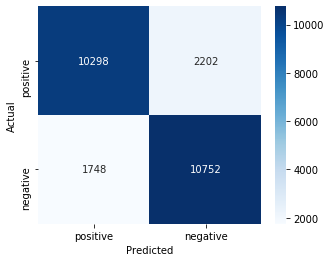

In [16]:
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test,test_pred,labels=[1,0])
df_cm = pd.DataFrame(cm,index = ['positive','negative'] ,columns=['positive','negative'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
akws = {"ha": 'center',"va": 'center'}
ax = sns.heatmap(df_cm,cmap = 'Blues',annot=True,fmt='d',annot_kws=akws,xticklabels=True,yticklabels=True)
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

In [17]:
print(classification_report(df_test['Rating'],test_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## Neural Networks

In [19]:
np.random.seed(1)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=0.25,random_state=1)

model = Sequential()
model.add(Dense(64, input_shape=(5000,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


early_stopping = EarlyStopping(patience=7)


model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train,y_train,epochs=100,batch_size=150,validation_data=(x_val,y_val),callbacks=[early_stopping])

Train on 25000 samples, validate on 6250 samples
Epoch 1/100
25000/25000 [==============================] - 5s 184us/step - loss: 0.6837 - accuracy: 0.6748 - val_loss: 0.6668 - val_accuracy: 0.8133
Epoch 2/100
25000/25000 [==============================] - 3s 110us/step - loss: 0.6382 - accuracy: 0.8161 - val_loss: 0.6063 - val_accuracy: 0.8384
Epoch 3/100
25000/25000 [==============================] - 3s 122us/step - loss: 0.5673 - accuracy: 0.8444 - val_loss: 0.5307 - val_accuracy: 0.8525
Epoch 4/100
25000/25000 [==============================] - 3s 106us/step - loss: 0.4868 - accuracy: 0.8611 - val_loss: 0.4532 - val_accuracy: 0.8584
Epoch 5/100
25000/25000 [==============================] - 3s 107us/step - loss: 0.4132 - accuracy: 0.8692 - val_loss: 0.3903 - val_accuracy: 0.8669
Epoch 6/100
25000/25000 [==============================] - 3s 108us/step - loss: 0.3543 - accuracy: 0.8786 - val_loss: 0.3446 - val_accuracy: 0.8738
Epoch 7/100
25000/25000 [==============================] 

In [20]:
def loss_accuracy_plot(history):
    accuracy = history.history['accuracy']
    loss = history.history['loss']
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = history.epoch
    
    fig = make_subplots(rows=2, cols=1)
    
    fig.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                             line=dict(color='royalblue', width=4)),row=1,col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, name = 'Validation Loss',
                             line=dict(color='firebrick', width=4, dash='dot')),row=1,col=1)
    
        
    fig.add_trace(go.Scatter(x=epochs, y=accuracy, name='Train Accuracy',
                             line=dict(color='royalblue', width=4)),row=2,col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, name = 'Validation Accuracy',
                             line=dict(color='firebrick', width=4, dash='dot')),row=2,col=1)
    
    fig.update_layout(height=800, width=800, title_text="Loss and Accuracy")
    fig.show()
    
    
loss_accuracy_plot(history)

In [21]:
model = Sequential()
model.add(Dense(64, input_shape=(5000,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(x_train,y_train,epochs=12,batch_size=150)

Epoch 1/12
25000/25000 [==============================] - 3s 103us/step - loss: 0.6814 - accuracy: 0.6856
Epoch 2/12
25000/25000 [==============================] - 3s 107us/step - loss: 0.6240 - accuracy: 0.8242
Epoch 3/12
25000/25000 [==============================] - 2s 100us/step - loss: 0.5389 - accuracy: 0.8509
Epoch 4/12
25000/25000 [==============================] - 2s 94us/step - loss: 0.4528 - accuracy: 0.8665
Epoch 5/12
25000/25000 [==============================] - 2s 94us/step - loss: 0.3826 - accuracy: 0.8742
Epoch 6/12
25000/25000 [==============================] - 2s 96us/step - loss: 0.3302 - accuracy: 0.8846
Epoch 7/12
25000/25000 [==============================] - 2s 97us/step - loss: 0.2968 - accuracy: 0.8899
Epoch 8/12
25000/25000 [==============================] - 3s 113us/step - loss: 0.2711 - accuracy: 0.8971
Epoch 9/12
25000/25000 [==============================] - 3s 108us/step - loss: 0.2559 - accuracy: 0.9006
Epoch 10/12
25000/25000 [=========================

In [22]:
model.evaluate(x_test,y_test)

18750/18750 [==============================] - 1s 77us/step


[0.2822975337028503, 0.8803733587265015]

We are getting a test accuracy of 0.88 which is better than NaiveBayes model

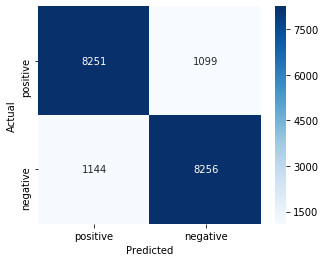

In [24]:
predictions = model.predict(x_test)

plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test,predictions.round(),labels=[1,0])
df_cm = pd.DataFrame(cm,index = ['positive','negative'] ,columns=['positive','negative'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
akws = {"ha": 'center',"va": 'center'}
ax = sns.heatmap(df_cm,cmap = 'Blues',annot=True,fmt='d',annot_kws=akws,xticklabels=True,yticklabels=True)
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

In [25]:
model.save('IMDB_Reviews_NN_model.h5')